### Logistic Regression models

**Objective**: This notebook aims to analyse customer reviews using Logistic Regression models to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed Logistic Regression with L1 regularisation to optimise the model's performance, which helps in feature selection by penalising less important features. The data is vectorised using 1 and 2-grams to capture the context within the text effectively. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**: The top three words associated with positive reviews are "love", "great" and "perfect". The top three words associated with negative reviews are "return", "broke" and "waste". This is consistant between both models. The model on unbalanced data scored an accuracy of $0.72$, and the model on balanced data achieved an accuracy of $0.79$. More analysis takes place in the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, auc


Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [2]:
df = pd.read_pickle("../data/reviews_vector_ngrams.pkl")

In [3]:
df[:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 504 entries, overall to your
dtypes: float64(501), int64(2), object(1)
memory usage: 39.5+ KB


In [4]:
df.duplicated().sum()

0

In [5]:
# Splitting the main data
X=df[df.columns[4:]]
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
X.duplicated().sum()

92588

In [7]:
y_train.value_counts(normalize=True)

binary
1    0.760141
0    0.239859
Name: proportion, dtype: float64

In [8]:
# function for downsampling X_train
def downsample_binary(y_t, x_t, min = 0, maj=1):
    # combine x and y
    data = pd.concat([y_t, x_t], axis=1)
    target_name = data.columns[0]
    
    # count the instances of the minority class
    minority_count = data[data[target_name] == min].shape[0]
    
    # random sample from the majority class
    majority_sample = data[data[target_name] == maj].sample(n=minority_count, random_state=42)
    
    # merge together
    balanced_df = pd.concat([data[data[target_name] == min], majority_sample])
    
    # Shuffle
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df

balanced_set = downsample_binary(y_train, X_train)

In [9]:
# balanced class training sets
X_train_bal = balanced_set.drop("binary", axis=1)
y_train_bal = balanced_set["binary"]


In [10]:
# checking that the downsample worked
y_train.value_counts(), y_train_bal.value_counts()

(binary
 1    436494
 0    137734
 Name: count, dtype: int64,
 binary
 0    137734
 1    137734
 Name: count, dtype: int64)

Now we can scale the data for evaluation and then train a pipeline to find the best $C$ value.

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [12]:
scaler_bal = StandardScaler()
scaler_bal.fit(X_train_bal)
X_train_transformed_bal = scaler_bal.transform(X_train_bal)
X_test_transformed_bal = scaler_bal.transform(X_test)

### Optimizing a Logistic Regression on the original unbalanced data


In [14]:
# instansiate the pipeline
estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)


In [16]:
# run a grid search for the model on unbalanced data
params = {
    'model__C': [0.1,1,10,1000],
    'model__random_state':[42],
    'normalise': [StandardScaler()]
    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [28]:
# fit the grid search
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.6min
[CV 2/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.9min
[CV 3/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 1.9min
[CV 4/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.7min
[CV 1/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.7min
[CV 5/5] END model__C=10, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.7min
[CV 2/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 2.2min
[CV 3/5] END model__C=1000, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 2.2min
[CV 5/5] END model__C=1000, model__random_state=42, no

In [29]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [13]:

estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators)
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

### Optimizing a Logistic Regression on the balanced data


In [19]:
# instansiate the balanced pipeline
estimators_bal = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_bal = Pipeline(estimators_bal)

In [20]:
# run a grid search for the model on balanced data
params_bal = {
    'model__C': [0.1,1,10,1000],
    'model__random_state':[42],
    'normalise': [StandardScaler()]
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [21]:
fittedgrid_bal = grid_search_bal.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.3min
[CV 2/5] END model__C=0.1, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.7min
[CV 3/5] END model__C=0.1, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 1.6min
[CV 4/5] END model__C=0.1, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.3min
[CV 5/5] END model__C=0.1, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 1.4min
[CV 1/5] END model__C=1, model__random_state=42, normalise=StandardScaler();, score=0.854 total time= 1.5min
[CV 2/5] END model__C=1, model__random_state=42, normalise=StandardScaler();, score=0.851 total time= 2.0min
[CV 3/5] END model__C=1, model__random_state=42, normalise=StandardScaler();, score=0.852 total time= 2.0min
[CV 4/5] END model__C=1, model__random_state=42, normalise

In [22]:
fittedgrid_bal.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [14]:
estimators_bal = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_bal  = Pipeline(estimators_bal)

In [15]:
pipe_final_bal.fit(X_train_bal, y_train_bal)

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

## Analysis

We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [16]:
log_clas = pipe_final[-1]
log_clas_bal = pipe_final_bal[-1]

In [17]:
# predictions for unbalanced
y_pred_train = pipe_final.predict(X_train_transformed)
y_pred_test = pipe_final.predict(X_test_transformed)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_transformed)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_transformed_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
# predictions for balanced
y_pred_train_bal = pipe_final_bal.predict(X_train_transformed_bal)
y_pred_test_bal = pipe_final_bal.predict(X_test_transformed_bal)


/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7216924287913512, 0.7239373632956715)

In [21]:
accuracy_score(y_train_bal, y_pred_train_bal),accuracy_score(y_test, y_pred_test_bal)

(0.8037013373604194, 0.789590270134719)

## Plotting highest coefficients for positive and negative sentiment

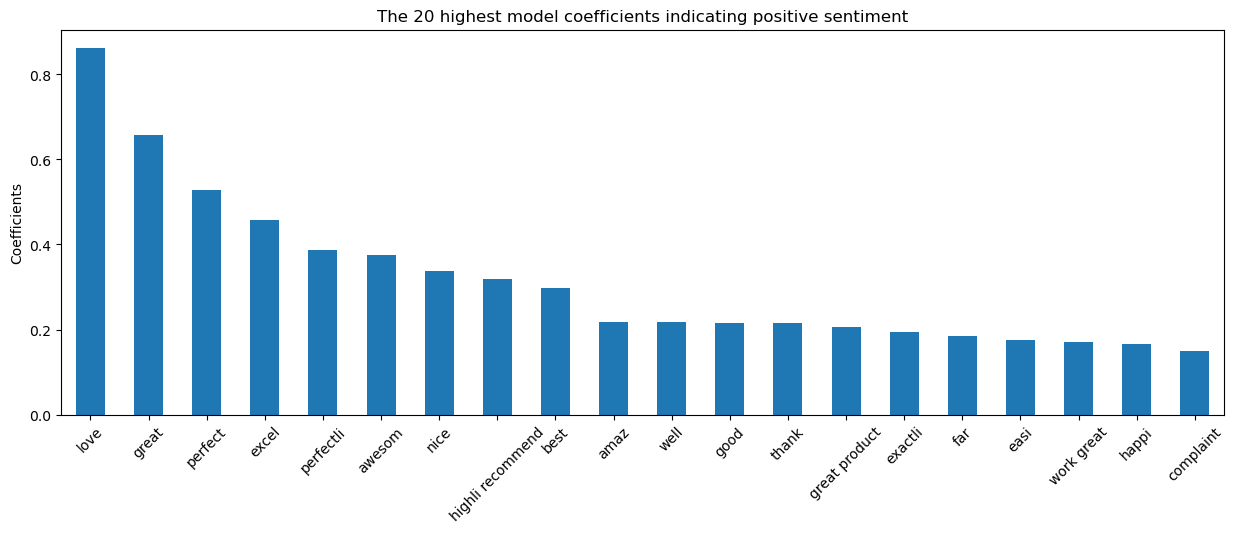

In [51]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=False)
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

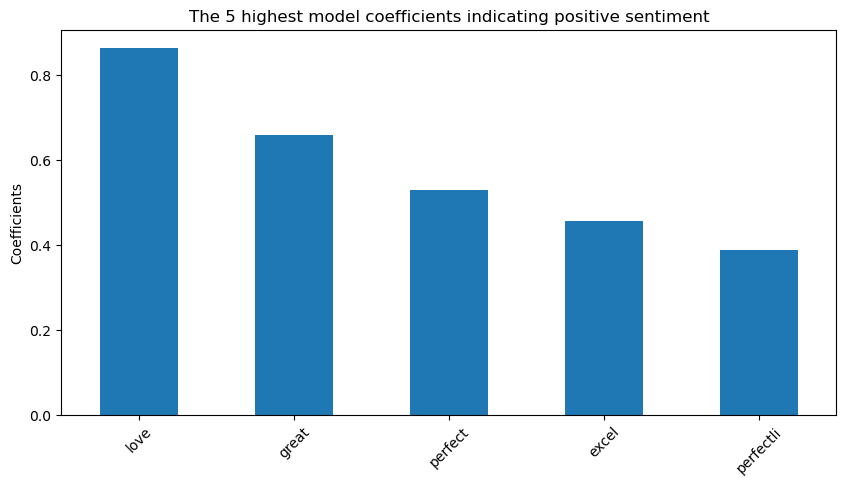

In [73]:
word_counts.head(5).plot(kind="bar", figsize=(10, 5), legend=False)

plt.title("The 5 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

We can see that the model identifies these words as the top words sigifying positive signal. This is reasonable as these words are positive

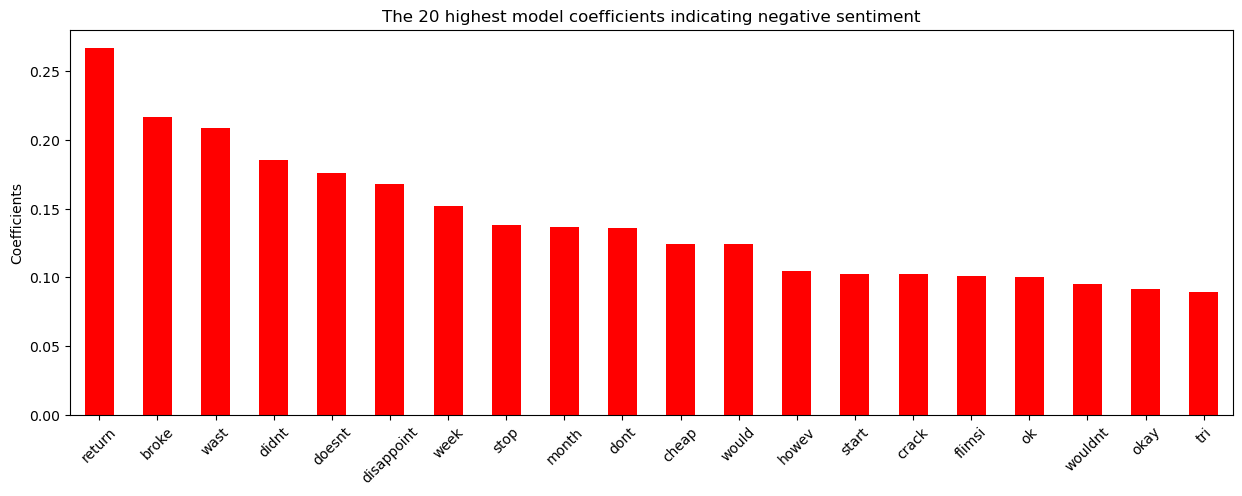

In [53]:
word_counts2 = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=True)

word_counts2.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

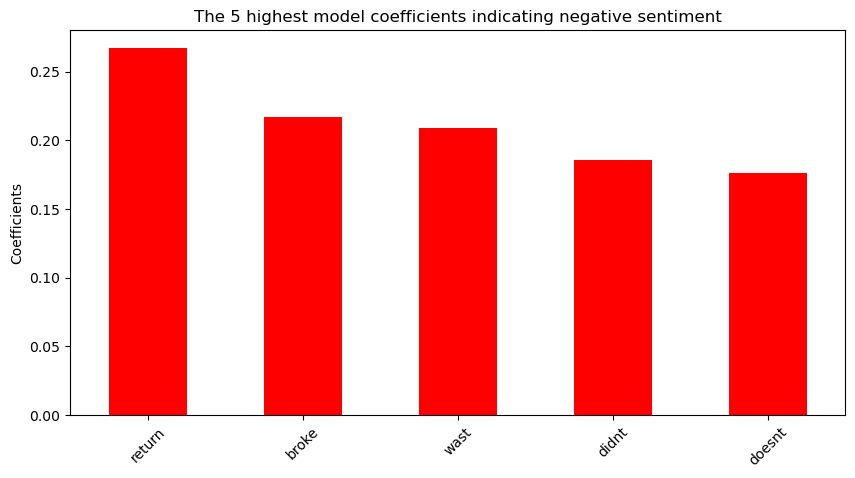

In [72]:
word_counts2.head(5).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

plt.title("The 5 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

Here are the top 5 words signifiying negative reviews. 

In [76]:
p = word_counts.head(5)
n = word_counts2.head(5)
p.columns = ['pos']
n.columns = ['neg']
p_and_n = pd.concat([p,n])
p_and_n

,pos,neg
love,0.862455,NaN
great,0.657306,NaN
perfect,0.527560,NaN
excel,0.456633,NaN
perfectli,0.387317,NaN
return,NaN,-0.266910
broke,NaN,-0.216709
wast,NaN,-0.208949
didnt,NaN,-0.185607
doesnt,NaN,-0.175869


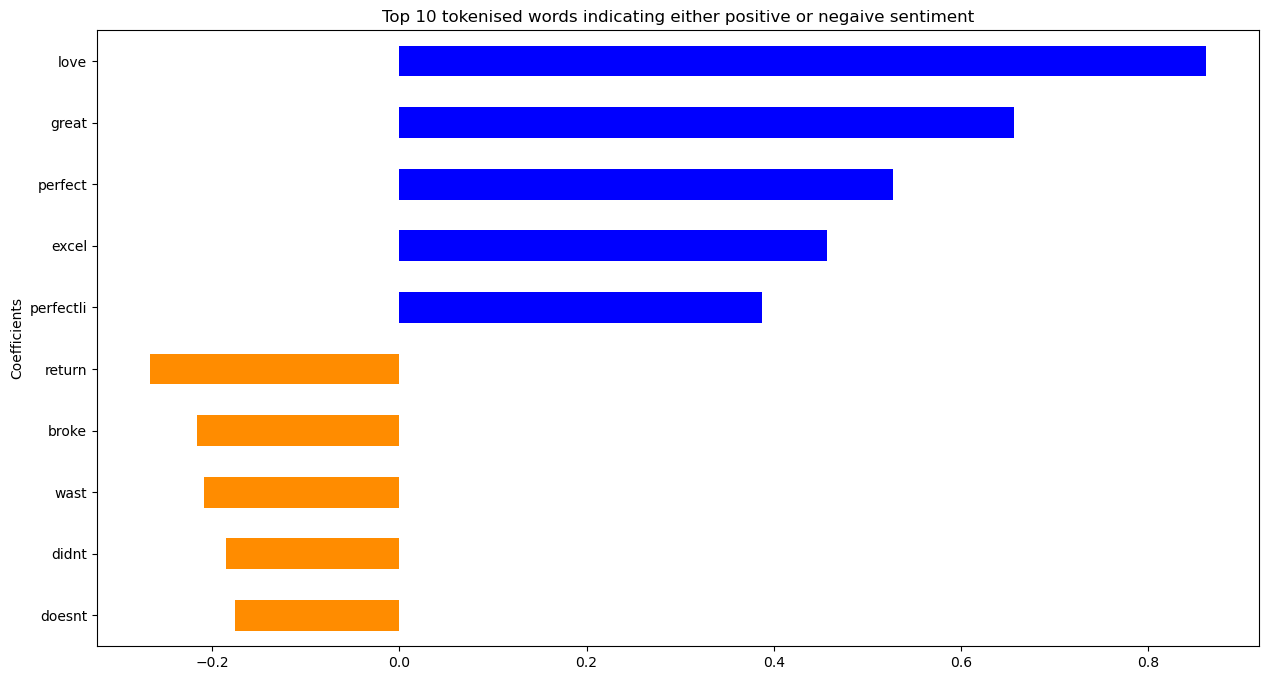

In [89]:
# coloring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data = p_and_n.stack().reset_index()
stacked_data.columns = ['feature', 'type', 'coefficient']
stacked_data
sorted_data = stacked_data.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['blue' if tp=="pos"  else 'darkorange' for tp in sorted_data['type']]

# plot
plt.figure(figsize=(15,8))
sorted_data.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Top 10 tokenised words indicating either positive or negaive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=0)
plt.show()

The same results for the balanced data, but in a slightly different order. It is interesting that no 2-grams were chosen as very important. maybe this was an unececary step and we can test this in future.

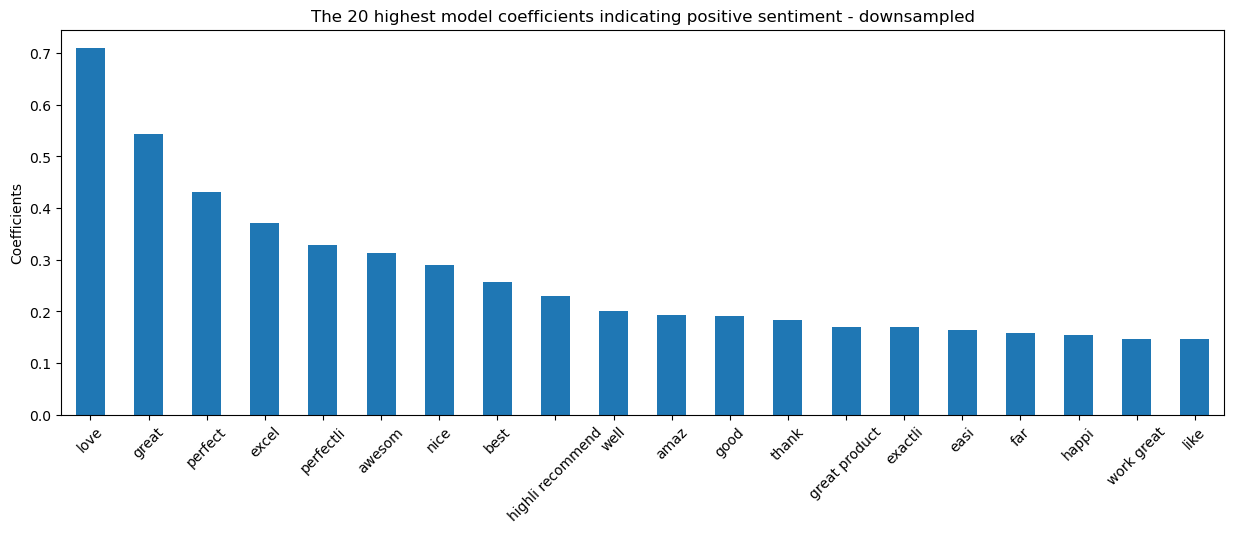

In [24]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=X_train_bal.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

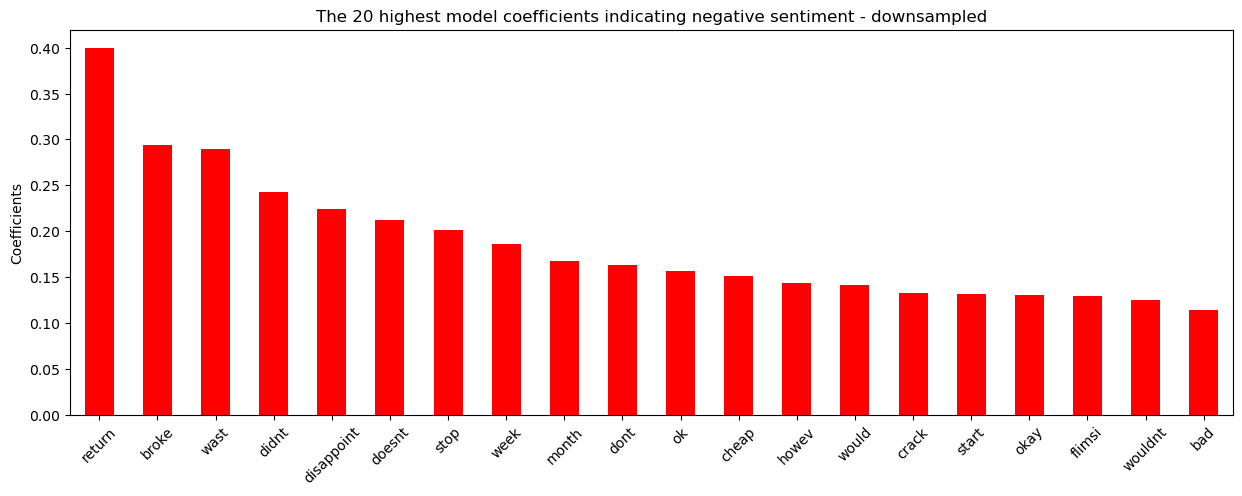

In [25]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=X_train_bal.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

We see that both in the positive and negative reviews the same words appear, although in slightly different orders. Many words we expect such as love, great, perfect indicate positive reviews, whilst words such as return waste dissapoint indicate a negative review. Lets look further into the predictions

Confusion matrix

In [26]:
# unbalanced
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
cm_count = confusion_matrix(y_test, y_pred_test)

In [27]:
# balanced
cm_bal = confusion_matrix(y_test, y_pred_test_bal, normalize="true")
cm_bal_count = confusion_matrix(y_test, y_pred_test_bal)

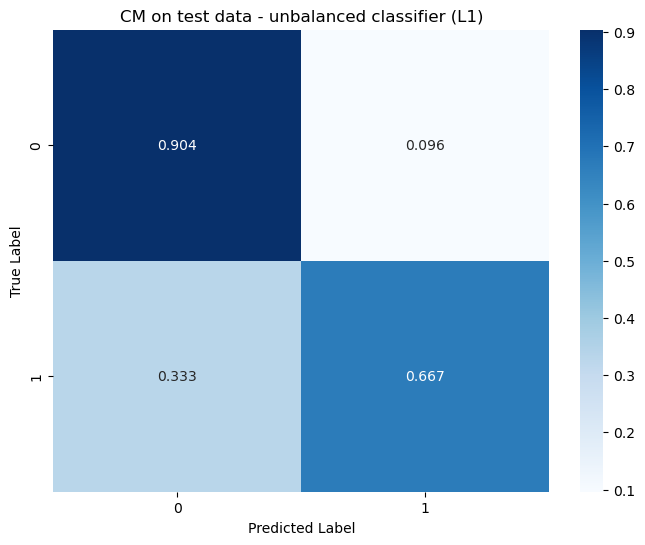

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CM on test data - unbalanced classifier (L1)")
plt.show()

we see that the first logistic regression is very good at predicting negative reviews, which is interesting as there are very few of them in comparison. however, it has overfitted, and predicts many positive reviews as negative.

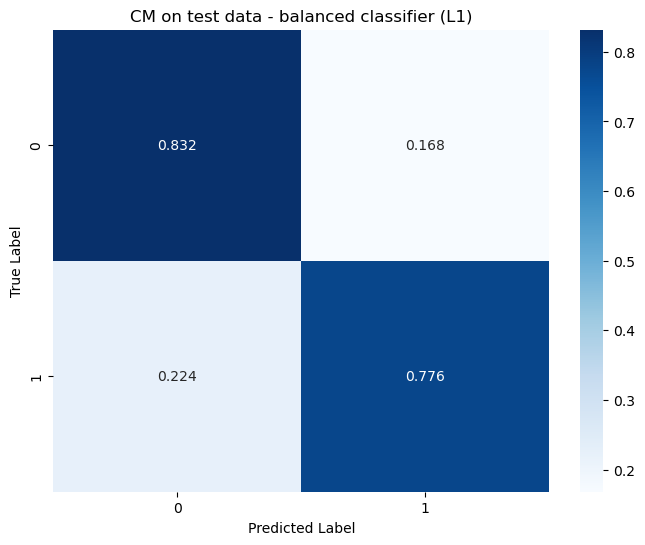

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CM on test data - balanced classifier (L1)")
plt.show()

The regression on the balanced data does better on positive reviews and slightly worse on negative, hwoever, it gets less wrong overall

In [30]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)
display1 = RocCurveDisplay(fpr=fpr_unbal, tpr=tpr_unbal, roc_auc=roc_auc1, estimator_name='Unbalanced LogReg')

In [31]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)
display2 = RocCurveDisplay(fpr=fpr_bal, tpr=tpr_bal, roc_auc=roc_auc2, estimator_name='Balanced LogReg')

We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

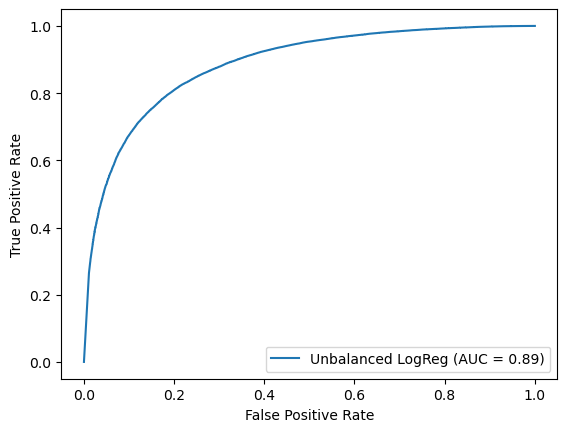

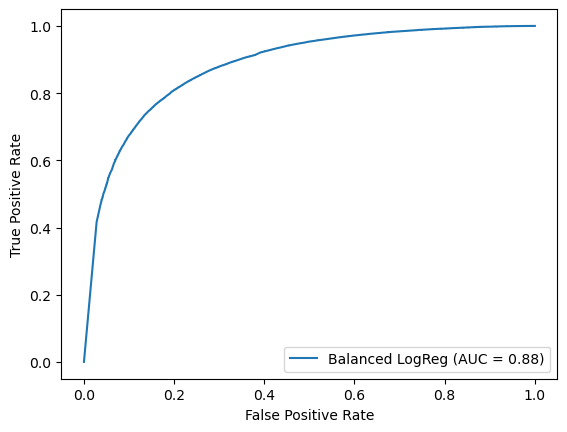

In [32]:
display1.plot()
display2.plot()
plt.show()

Really poor precision of the 0 class, and bad recall on the 1 class. It "performs well" by guessing 0 a lot. Then when its very confident it guesses 1 and gets it right, but misclassifies many positive reviews as negative.

In [33]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.46      0.90      0.61     34434
           1       0.96      0.67      0.79    109124

    accuracy                           0.72    143558
   macro avg       0.71      0.79      0.70    143558
weighted avg       0.84      0.72      0.74    143558



In [34]:
print(classification_report(y_test, y_pred_test_bal))

              precision    recall  f1-score   support

           0       0.54      0.83      0.65     34434
           1       0.94      0.78      0.85    109124

    accuracy                           0.79    143558
   macro avg       0.74      0.80      0.75    143558
weighted avg       0.84      0.79      0.80    143558



Similar results, but better overall at guessing each class.

In [35]:
y_pred_baseline= log_clas.predict(scaler.transform(df[df.columns[4:]]))

incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
ig = pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)


In [105]:
rev = ig.loc[2]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:45]} \n{text[45: 100]} \n{text[101:152]} \n{text[153:]}")

Actual: 0, Guess: 1, Overall: 3
Review: so the case came on time, i love the design.  
I'm actually missing 2 studs but nothing too noticeable 
the studding is almost a bit sloppy around the bow, 
but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far


In [106]:
feature_values = scaler.transform(ig.loc[2, ig.columns[5:]].values.reshape(1, -1))

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [107]:
coefficients = log_clas.coef_
contributions = feature_values * coefficients
feature_contributions = pd.DataFrame(contributions, columns=ig.columns[5:], index=['Contribution']).T
sorted_contributions = feature_contributions.sort_values(by='Contribution', ascending=False)

print(sorted_contributions.head(10))


        Contribution
love        0.604823
far         0.536384
notic       0.482069
yet         0.426528
ive         0.280960
havent      0.273942
bit         0.173136
time        0.084462
im          0.037672
doesnt      0.035985


We see that the positive words swayed the confidence of the model and it misclassified it. Words like love.

In [103]:
intercept = log_clas.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [104]:
probability

array([0.58285277])